# Modèle guide d'onde de McIntyre


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mvt_Helmholtz import *
import scipy.optimize as opt
import scipy.signal as sig
import scipy.integrate as intgr
from scipy.special import erf

$r(t-T) = -\alpha \delta(t-T)$

In [75]:
def retardT(L,c):
    '''Renvoie T le retard accumulé par l'onde
    en un aller-retour
    L : longueur du guide cylindrique
    c : célérité des ondes dans l'air
    '''
    return 2*L/c

def r_T(t,T,alpha,beta):
    #if abs(t-T)<1e-8:
    #    return -1
    #else :
    #    return 0 
    r_list = -alpha*np.exp(-beta*(t-T)**2)
    
    #aire = np.trapz(y=r_list, x=t)
    
    #aire = np.sqrt(np.pi)*alpha*(erf(T*np.sqrt(beta))+1)/(2*np.sqrt(beta))
    
    return r_list
    
def coeffs(gamma,zeta):
    '''Calcule les coefficients de la fonction de
    couplage F linéarisée
    F(p) = F0 + Ap + Bp**2 + Cp**3
    '''
    if gamma == 0:
        return 0, 0, 0, 0
    else :
        F0 = zeta*(1-gamma)*np.sqrt(gamma)
        A = zeta*(3 * gamma - 1) / 2 /np.sqrt(gamma)
        B = -zeta*(3*gamma+1)/8/gamma**(3/2)
        C = -zeta*(gamma+1)/16/gamma**(5/2)
    return F0,A,B,C
    
def F(p, gamma, zeta):
    '''Renvoit le débit u suivant la pression p
    suivant la relation u = F(p)'''
    if gamma == 0:
        return 0
    if gamma - p >= 1 or gamma - p < 0:
        return 0
    else:
        return zeta * (1 - gamma + p) * np.sqrt(gamma - p)

In [76]:
def tableau_F(pmin,pmax,nb_pts,gamma,zeta):
    tab_p = np.linspace(pmin,pmax,nb_pts)
    tab_F = np.zeros_like(tab_p)
    for i in range(nb_pts):
        tab_F[i] = F(tab_p[i],gamma,zeta)
    return tab_p, tab_F


def find_zero(tableau, i):
    """
    Recherche le point d'annulation de tableau le plus proche possible de i
    
    tableau = tableau des valeurs de la fonction F sur l'intervalle souhaité
    i =  
    """
    l = len(tableau)
    changement_signe = tableau[0:l-1]*tableau[1:l] # il y a un point d'annulation entre tableau[j] et tableau[j+1] ssi tableau[j]*tableau[j+1] <= 0
    negatif = changement_signe <= 0 # True aux indices où il y a un changement de signe
    tab_i0 = (np.arange(l-1))[negatif] # indices auxquels il y a un changement de signe
    if len(tab_i0)==0:
        return np.argmin(np.abs(tableau))
    i0 = np.argmin(np.abs(tab_i0-i)) # indice de l'indice le plus proche de i dans tab_i0
    return tab_i0[i0]

def convolution(ind_tau,reflex_list,signal_list,time):
    
    x1 = reflex_list[0:ind_tau+1]
    x2 = np.flipud(signal_list[0:ind_tau+1])
    
    integrate = intgr.trapz(y=x1*x2)  #,x=time[:ind_tau+1])
    
    return integrate

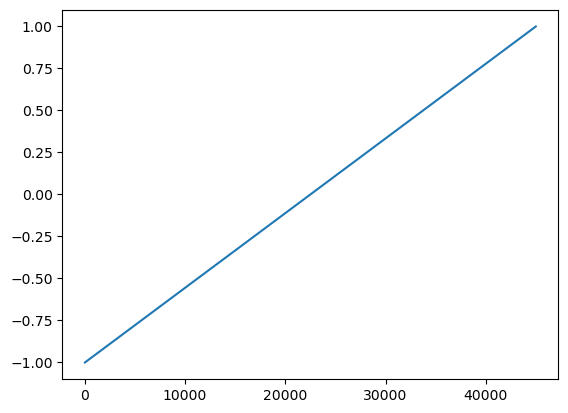

In [113]:
#p = np.zeros_like(compute_time)
#u = np.zeros_like(compute_time)

fe = 22500

L = 60e-2
c = 344
t_max = 1
rho = 1.292  # Masse vol air
r = 3e-2  # rayon de la clarinette
S = np.pi * r**2  # section clarinette

T = retardT(L,c)

time = (np.arange(int(2*t_max * fe)) / fe) - t_max # temps de simulation allant de -1s à 1s 
plt.plot(time)

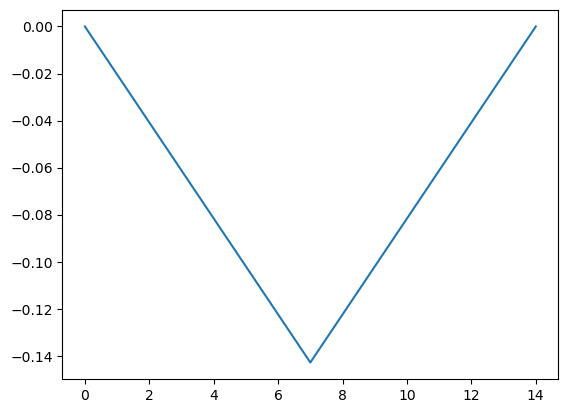

In [117]:
time = np.arange(int(t_max * fe)) / fe
indT = int(T*fe)
reflex_list = np.zeros(len(time))

delta_ind = indT//10

pente = 1/delta_ind

for i in range(indT-delta_ind, indT+1):
    reflex_list[i] = (i-indT+delta_ind)*pente

for i in range(indT+1, indT+delta_ind+1):
    reflex_list[i] = reflex_list[indT] - (i-indT)*pente
    
aire = np.sum(reflex_list)

reflex_list = -reflex_list/aire
    
plt.plot(reflex_list[indT-delta_ind: indT+delta_ind+1])


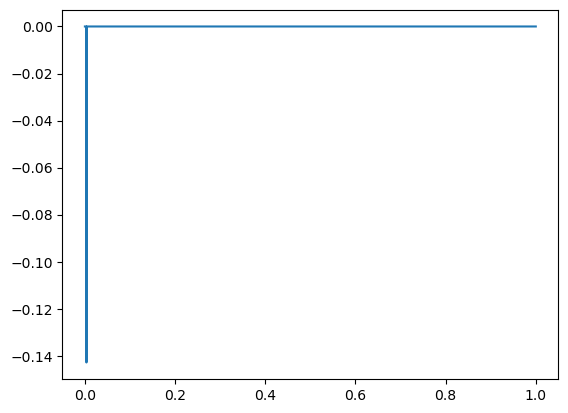

In [118]:
Nsim = len(time)

p = np.zeros_like(time)
u = np.zeros_like(time)


gamma = 0.6
zeta = 0.4
tab_p, tab_F = tableau_F(-5,5,2000,gamma,zeta)
solvF = tab_p - tab_F

i_act = np.argmin(np.abs(tab_p-gamma)) + 1

plt.plot(time, reflex_list)

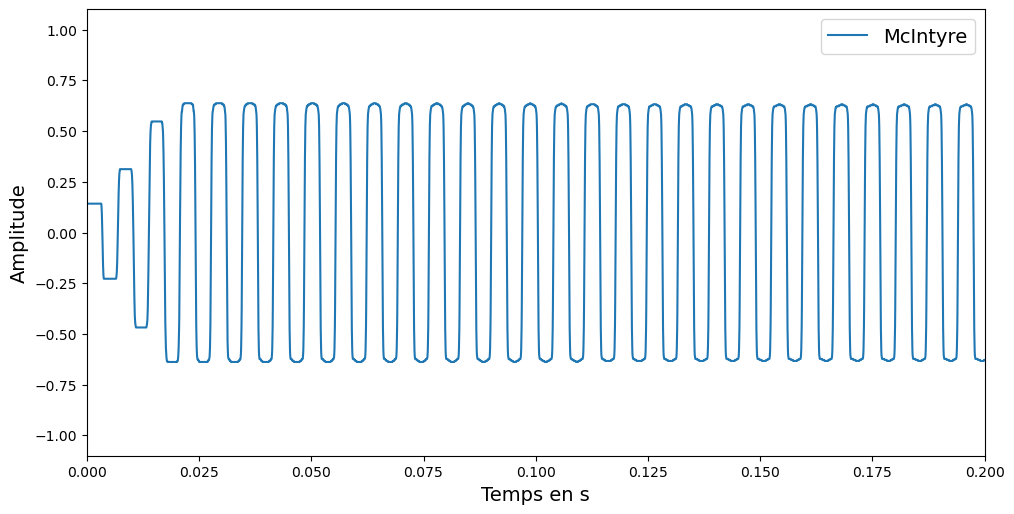

In [119]:
#reflex_list = np.zeros(Nsim)
#reflex_list[indT] = -1

for j in range(Nsim):  # cas avec dirac en réflexion
    
    #if j < indT+1:
    #    ph = -(p[0]+u[0]) 
    #else:
    #    ph = -(p[j-indT]+u[j-indT]) 
    
    ph = convolution(ind_tau=j,reflex_list = reflex_list, signal_list = p + u,time=sim_time)
    i = find_zero(solvF-ph,i_act)
    i_act = i
    p[j] = tab_p[i]
    u[j] = tab_F[i]
    
plt.figure(figsize=(10,5))
plt.plot(time,p,label="McIntyre")
#plt.plot(sim_time,p_maganza*np.max(p)/np.max(p_maganza),label="Maganza")
plt.xlim(0,0.2)
plt.ylim(-1.1, 1.1)
plt.tight_layout()
plt.xlabel("Temps en s",size=14)
plt.ylabel("Amplitude",size=14)
plt.legend(fontsize=14)
plt.show()

Code à modifier : pour intégrer une vraie convolution (pour pouvoir changer la fonction de réflexion), et donc il faut faire le calcul sur les dt plus petits que T.

Comparer avec modèle Maganza, parce que les résultats me paraissent zarb... (peut-être juste un pb d'échelle) 